<a href="https://colab.research.google.com/github/VitaliiZaitsev/ApacheSpark/blob/main/Spark_Lesson_3_Vitaly_Zaitsev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Урок 3. Самостоятельная работа
На уроке мы попробовали оконные и пользовательские функции. Теперь закрепим полученные знания.

## Данные: [google drive: raw_sales.csv](https://drive.google.com/file/d/1G2N7Mnt4-Tqz4JdJxutGDMbJiOr32kZp/view?usp=sharing)

 Каждая строчка это продажа жилья, которая состоит из следующих полей (думаю описание не требуется):
*   date of sale
*   price
*   property type
*   number of bedrooms
*   4digit postcode

## Подготовка

In [ ]:
# устанаваливаем pyspark
pip install pyspark

     |████████████████████████████████| 281.3 MB 33 kB/s 
     |████████████████████████████████| 198 kB 48.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=8865a61301dde95a0c800bb6e4d96a27adb4ab969eee313015050d37d6415bef
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
# Создаём spark context
from pyspark.sql import SparkSession
spark = SparkSession.builder\
    .master("local[3]")\
    .appName("Lesson_3")\
    .config("spark.executor.instances",2)\
    .config("spark.executor.memory",'2g')\
    .config("spark.executor.cores",1)\
    .getOrCreate()
sc = spark.sparkContext

In [ ]:
sc

<SparkContext master=local[3] appName=Lesson_3>

Загружаем файл с ланными / проверяем что файл загружен
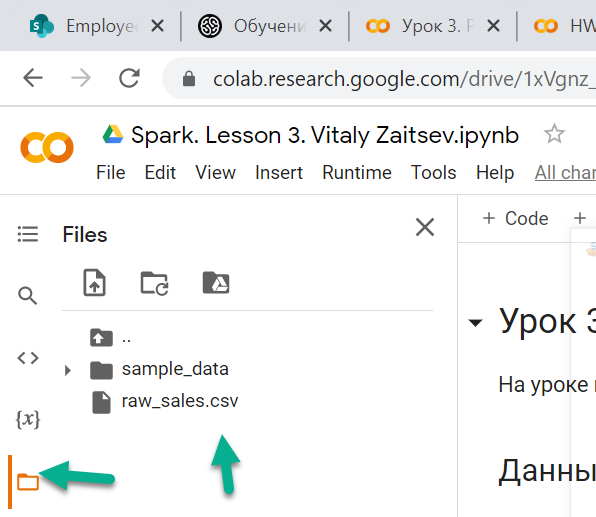

## Задание 1
Добавьте к таблице следующие поля:
*  Средняя стомость 10 проданных домов до текущего в том же районе (4digit postcode) (1 балл)
*  Средняя стомость 10 проданных домов после текущего в том же районе (4digit postcode) (1 балл)
*  Стоимость последнего проданного дома до текущего (1 балл)


In [ ]:
# Инициализируем источник данных
raw_sales = spark.read.csv('raw_sales.csv', header = True, inferSchema = True)

In [ ]:
# Количество записей
raw_sales.count()

29580

In [ ]:
# Структура и первые 5 записей
raw_sales.show(5)

+-------------------+--------+------+------------+--------+
|           datesold|postcode| price|propertyType|bedrooms|
+-------------------+--------+------+------------+--------+
|2007-02-07 00:00:00|    2607|525000|       house|       4|
|2007-02-27 00:00:00|    2906|290000|       house|       3|
|2007-03-07 00:00:00|    2905|328000|       house|       3|
|2007-03-09 00:00:00|    2905|380000|       house|       4|
|2007-03-21 00:00:00|    2906|310000|       house|       3|
+-------------------+--------+------+------------+--------+
only showing top 5 rows



In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import Window

# Держим задание перед глазами:
# Средняя стомость 10 проданных домов до текущего в том же районе (4digit postcode)
# Средняя стомость 10 проданных домов после текущего в том же районе (4digit postcode)
# Стоимость последнего проданного дома до текущего


# https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql.html
# Window.rowsBetween(start, end)
# Creates a WindowSpec with the frame boundaries defined, from start (inclusive) to end (inclusive).

window_price_before_current = Window.partitionBy('postcode').orderBy('datesold').rowsBetween(Window.currentRow-10, Window.currentRow)
window_price_after_current = Window.partitionBy('postcode').orderBy('datesold').rowsBetween(Window.currentRow + 1, Window.currentRow + 1 + 10)
window_lastprice_before_current = Window.orderBy('datesold').rowsBetween(Window.currentRow - 1, Window.currentRow - 1)

In [ ]:
# "Эти 3 поля требуется добавить к таблице"

# https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql.html
# DataFrame.withColumn(colName, col)
# Returns a new DataFrame by adding a column or replacing the existing column that has the same name.
#
# Column.over(window)
# Define a windowing column.

# пусть будет результирующая таблица, к ней добавляем поля
raw_sales_modified = raw_sales.withColumn('avg_price_for_10_deals_before', F.round(F.avg('price').over(window_price_before_current), 2))
raw_sales_modified = raw_sales_modified.withColumn('avg_price_for_10_deals_after', F.round(F.avg('price').over(window_price_after_current), 2))
raw_sales_modified = raw_sales_modified.withColumn('last_deal_price', F.sum('price').over(window_lastprice_before_current))


In [ ]:
# Проверяем результат
raw_sales_modified.show(30)

+-------------------+--------+-------+------------+--------+-----------------------------+----------------------------+---------------+
|           datesold|postcode|  price|propertyType|bedrooms|avg_price_for_10_deals_before|avg_price_for_10_deals_after|last_deal_price|
+-------------------+--------+-------+------------+--------+-----------------------------+----------------------------+---------------+
|2007-07-08 00:00:00|    2600| 327000|       house|       1|                     327000.0|                   706681.82|         900000|
|2007-08-16 00:00:00|    2600| 790000|       house|       4|                     558500.0|                   692590.91|         625000|
|2007-12-05 00:00:00|    2600| 825000|       house|       3|                    647333.33|                   703954.55|         620000|
|2008-01-21 00:00:00|    2600| 315000|        unit|       1|                     564250.0|                   741681.82|         580000|
|2008-04-24 00:00:00|    2600| 292500|       hou

## Задание 2
Найдите среднюю цену жилья для каждого года и приджойните эти данные к таблице из задания 1.


*(left join on a.year(date of sale) = b.year, где a - таблица из первого задания, а b таблица после группировки)*

In [ ]:
# Считаем среднегодовые цены
average_year_price = raw_sales.select(F.year('datesold').alias('year'), 'price') \
                          .groupBy('year').agg(F.round(F.avg('price'), 2).alias('average_year_price')) \
                          .orderBy('year')

In [ ]:
average_year_price.show()

+----+------------------+
|year|average_year_price|
+----+------------------+
|2007|         522377.21|
|2008|         493814.16|
|2009|         496092.03|
|2010|         559564.81|
|2011|         566715.11|
|2012|         552501.37|
|2013|          553416.3|
|2014|         592653.76|
|2015|         626101.34|
|2016|         635185.31|
|2017|         671880.55|
|2018|         660701.04|
|2019|         634184.22|
+----+------------------+



In [ ]:
# Получаем итоговую таблицу, с добавлением средней цены в год сделки
# raw_sales_modified
# avg_price_for_10_deals_before, avg_price_for_10_deals_after, last_deal_price
# average_year_price
raw_sales_average_year_price = raw_sales_modified.join(average_year_price, on=[F.year(raw_sales_modified['datesold']) == average_year_price['year']], how='left') \
                            .select('datesold', 'postcode', 'propertyType', 'bedrooms', 
                                    'price', 'avg_price_for_10_deals_before', 'avg_price_for_10_deals_after', 'last_deal_price', 'average_year_price',)

In [ ]:
raw_sales_average_year_price.show()

+-------------------+--------+------------+--------+-------+-----------------------------+----------------------------+---------------+------------------+
|           datesold|postcode|propertyType|bedrooms|  price|avg_price_for_10_deals_before|avg_price_for_10_deals_after|last_deal_price|average_year_price|
+-------------------+--------+------------+--------+-------+-----------------------------+----------------------------+---------------+------------------+
|2007-07-08 00:00:00|    2600|       house|       1| 327000|                     327000.0|                   706681.82|         900000|         522377.21|
|2007-08-16 00:00:00|    2600|       house|       4| 790000|                     558500.0|                   692590.91|         625000|         522377.21|
|2007-12-05 00:00:00|    2600|       house|       3| 825000|                    647333.33|                   703954.55|         620000|         522377.21|
|2008-01-21 00:00:00|    2600|        unit|       1| 315000|          

## Задание 3
В итоге у вас таблица с колонками (или нечто похожее):
*   price
*   Среднегодовая цена
*  Средняя стомость 10 проданных домов до текущего в том же районе (4digit postcode) (1 балл)
*  Средняя стомость 10 проданных домов после текущего в том же районе (4digit postcode) (1 балл)
*  Стоимость последнего проданного дома до текущего ((1 балл)
*  и др.

Посчитайте кол-во уникальных значений в каждой строчке (unique(row)). (2 балла)

In [ ]:
raw_sales_average_year_price.show(5)

+-------------------+--------+------------+--------+------+-----------------------------+----------------------------+---------------+------------------+
|           datesold|postcode|propertyType|bedrooms| price|avg_price_for_10_deals_before|avg_price_for_10_deals_after|last_deal_price|average_year_price|
+-------------------+--------+------------+--------+------+-----------------------------+----------------------------+---------------+------------------+
|2007-07-08 00:00:00|    2600|       house|       1|327000|                     327000.0|                   706681.82|         900000|         522377.21|
|2007-08-16 00:00:00|    2600|       house|       4|790000|                     558500.0|                   692590.91|         625000|         522377.21|
|2007-12-05 00:00:00|    2600|       house|       3|825000|                    647333.33|                   703954.55|         620000|         522377.21|
|2008-01-21 00:00:00|    2600|        unit|       1|315000|                 

In [ ]:
# Чудо функция, что считает количество уникальных значений на вход
@F.udf('string')
def unique_values_number(value):
    value = list(map(str, value))
    return len(set(value))

In [ ]:
# Добавляем столбец-количество уникальных значениях в каждой строчке
raw_sales_average_year_price.select('*', unique_values_number(F.array(raw_sales_average_year_price.columns)).alias('unique_values_number')).show()

+-------------------+--------+------------+--------+-------+-----------------------------+----------------------------+---------------+------------------+--------------------+
|           datesold|postcode|propertyType|bedrooms|  price|avg_price_for_10_deals_before|avg_price_for_10_deals_after|last_deal_price|average_year_price|unique_values_number|
+-------------------+--------+------------+--------+-------+-----------------------------+----------------------------+---------------+------------------+--------------------+
|2007-07-08 00:00:00|    2600|       house|       1| 327000|                     327000.0|                   706681.82|         900000|         522377.21|                   9|
|2007-08-16 00:00:00|    2600|       house|       4| 790000|                     558500.0|                   692590.91|         625000|         522377.21|                   9|
|2007-12-05 00:00:00|    2600|       house|       3| 825000|                    647333.33|                   703954.55| 

In [ ]:
# P.S.
# Сначала я посчитал количество уникальных значений в каждом СТОЛБЦЕ
# Оставил этот код, пусть будет
#
# Используем подсказку https://community.databricks.com/s/question/0D53f00001HKHe4CAH/how-to-get-unique-values-of-a-column-in-pyspark-dataframe
# df.select(F.countDistinct("colx")).show()
raw_sales_average_year_price.select(F.countDistinct("datesold")).show()

+------------------------+
|count(DISTINCT datesold)|
+------------------------+
|                    3582|
+------------------------+



In [ ]:
# или так
# datesold postcode propertyType bedrooms price avg_price_for_10_deals_before avg_price_for_10_deals_after last_deal_price average_year_price
raw_sales_average_year_price.select(F.countDistinct("datesold"), F.countDistinct("postcode"), F.countDistinct("propertyType"), F.countDistinct("bedrooms"), \
                                    F.countDistinct("price"), F.countDistinct("avg_price_for_10_deals_before"), F.countDistinct("avg_price_for_10_deals_after"), \
                                    F.countDistinct("last_deal_price"), F.countDistinct("average_year_price")).show()

+------------------------+------------------------+----------------------------+------------------------+---------------------+---------------------------------------------+--------------------------------------------+-------------------------------+----------------------------------+
|count(DISTINCT datesold)|count(DISTINCT postcode)|count(DISTINCT propertyType)|count(DISTINCT bedrooms)|count(DISTINCT price)|count(DISTINCT avg_price_for_10_deals_before)|count(DISTINCT avg_price_for_10_deals_after)|count(DISTINCT last_deal_price)|count(DISTINCT average_year_price)|
+------------------------+------------------------+----------------------------+------------------------+---------------------+---------------------------------------------+--------------------------------------------+-------------------------------+----------------------------------+
|                    3582|                      27|                           2|                       6|                 2554|               

# END